#Experiment design


We consider the problem of estimating a vector $x \in \mathbf{R}^{n}$ from measurements or experiments
$$
y_{i}=a_{i}^{T} x+w_{i}, \quad i=1, \ldots, m
$$
where $w_{i}$ is measurement noise. We assume that $w_{i}$ are independent Gaussian random variables with zero mean and unit variance, and that the measurement vectors $a_{1}, \ldots, a_{m}$ span $\mathbf{R}^{n}$. The maximum likelihood estimate of $x$, which is the same as the minimum variance estimate, is given by the least-squares solution
$$
\hat{x}=\left(\sum_{i=1}^{m} a_{i} a_{i}^{T}\right)^{-1} \sum_{i=1}^{m} y_{i} a_{i}
$$
The associated estimation error $e=\hat{x}-x$ has zero mean and covariance matrix
$$
E=\mathbf{E} e e^{T}=\left(\sum_{i=1}^{m} a_{i} a_{i}^{T}\right)^{-1}
$$
The matrix $E$ characterizes the accuracy of the estimation, or the informativeness of the experiments. For example the $\alpha$ -confidence level ellipsoid for $x$ is given by
$$
\mathcal{E}=\left\{z \mid(z-\hat{x})^{T} E^{-1}(z-\hat{x}) \leq \beta\right\}
$$
where $\beta$ is a constant that depends on $n$ and $\alpha$. We suppose that the vectors $a_{1}, \ldots, a_{m},$ which characterize the measurements, can be chosen among $p$ possible test vectors $v_{1}, \ldots, v_{p} \in \mathbf{R}^{n},$ i.e., each $a_{i}$ is one of the $v_{j} .$ The goal of experiment design is to choose the vectors $a_{i},$ from among the possible choices, so that the error covariance $E$ is small (in some sense). In other words, each of $m$ experiments or measurements can be chosen from a fixed menu of $p$ possible experiments; our job is to find a set of measurements that (together) are maximally informative.

The basic experiment design problem is as follows. Given the menu of possible choices for experiments, i.e., $v_{1}, \ldots, v_{p},$ and the total number $m$ of experiments to be carried out, choose the numbers of each type of experiment, i.e., $m_{1}, \ldots, m_{p}$, to make the error covariance $E$ small (in some sense). The variables $m_{1}, \ldots, m_{p}$ must, of course, be integers and sum to $m,$ the given total number of experiments. This leads to the optimization problem
$$
\begin{array}{ll}
\operatorname{minimize}\left(\text { w.r.t. } \mathbf{S}_{+}^{n}\right) & E=\left(\sum_{j=1}^{p} m_{j} v_{j} v_{j}^{T}\right)^{-1} \\
\text {subject to } & m_{i} \geq 0, \quad m_{1}+\cdots+m_{p}=m \\
& m_{i} \in \mathbf{Z},
\end{array}
$$
where the variables are the integers $m_{1}, \ldots, m_{p}$

In [10]:
from math import pi, log, sqrt
from cvxopt import blas, lapack, solvers
from cvxopt import matrix, spmatrix, spdiag, mul, cos, sin
solvers.options['show_progress'] = False

try: import pylab
except ImportError: pylab_installed = False
else: pylab_installed = True

V = matrix([-2.1213,    2.1213,
            -2.2981,    1.9284,
            -2.4575,    1.7207,
            -2.5981,    1.5000,
            -2.7189,    1.2679,
            -2.8191,    1.0261,
            -2.8978,    0.7765,
            -2.9544,    0.5209,
            -2.9886,    0.2615,
            -3.0000,    0.0000,
             1.5000,    0.0000,
             1.4772,   -0.2605,
             1.4095,   -0.5130,
             1.2990,   -0.7500,
             1.1491,   -0.9642,
             0.9642,   -1.1491,
             0.7500,   -1.2990,
             0.5130,   -1.4095,
             0.2605,   -1.4772,
             0.0000,   -1.5000 ], (2,20))

n = V.size[1]
G = spmatrix(-1.0, range(n), range(n))
h = matrix(0.0, (n,1))
A = matrix(1.0, (1,n))
b = matrix(1.0)

**D-desing**

The most widely used scalarization is called D-optimal design, in which we minimize
the determinant of the error covariance matrix E. This corresponds to designing
the experiment to minimize the volume of the resulting confidence ellipsoid (for
a fixed confidence level).

\begin{array}{c}
\min F(x)=-\log \operatorname{det}\left(V \operatorname{diag}(x) V^{\prime}\right) \\
\text { S.t. } x \geq 0 \quad \sum(x)=1
\end{array}

The gradient and Hessian of f are
\begin{array}{l}
\nabla F=-\operatorname{diag}\left(V^{\prime} X^{-1} V\right) \\
H=\left(V^{\prime} X^{-1} V\right)^{2} \\
\text { where } \\
X=V \text { diag } V^{\prime}
\end{array}

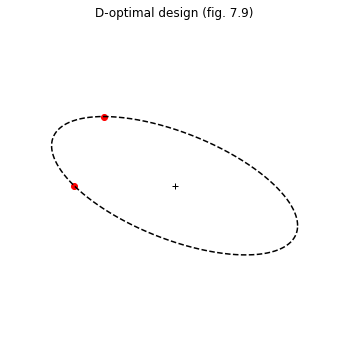

In [9]:
def F(x=None, z=None):
    if x is None: return 0, matrix(1.0, (n,1))
    X = V * spdiag(x) * V.T
    L = +X
    try: lapack.potrf(L)
    except ArithmeticError: return None
    f = - 2.0 * (log(L[0,0])  + log(L[1,1]))
    W = +V
    blas.trsm(L, W)
    gradf = matrix(-1.0, (1,2)) * W**2
    if z is None: return f, gradf
    H = matrix(0.0, (n,n))
    blas.syrk(W, H, trans='T')
    return f, gradf, z[0] * H**2
xd = solvers.cp(F, G, h, A = A, b = b)['x']

if pylab_installed:
    pylab.figure(1, facecolor='w', figsize=(6,6))
    pylab.plot(V[0,:], V[1,:],'ow', [0], [0], 'k+')
    I = [ k for k in range(n) if xd[k] > 1e-5 ]
    pylab.plot(V[0,I], V[1,I],'or')

nopts = 1000
angles = matrix( [ a*2.0*pi/nopts for a in range(nopts) ], (1,nopts) )
circle = matrix(0.0, (2,nopts))
circle[0,:], circle[1,:] = cos(angles), sin(angles)

W = V * spdiag(xd) * V.T
lapack.potrf(W)
ellipse = sqrt(2.0) * circle
blas.trmm(W, ellipse)
if pylab_installed:
    pylab.plot(ellipse[0,:].T, ellipse[1,:].T, 'k--')
    pylab.axis([-5, 5, -5, 5])
    pylab.title('D-optimal design (fig. 7.9)')
    pylab.axis('off')

Enclosing ellipse is 
$\left\{x \mid x^{\prime}\left(V \operatorname{diag}(x e) V^{\prime}\right)^{-1} x=sqrt({2})\right\}$

**E-desing**

In $E$ -optimal design, we minimize the norm of the error covariance matrix, $i . e .,$ the maximum eigenvalue of $E$. Since the diameter (twice the longest semi-axis) of the confidence ellipsoid $\mathcal{E}$ is proportional to $\|E\|_{2}^{1 / 2},$ minimizing $\|E\|_{2}$ can be interpreted geometrically as minimizing the diameter of the confidence ellipsoid. $E$ -optimal design can also be interpreted as minimizing the maximum variance of $q^{T} e,$ over all $q$ with $\|q\|_{2}=1$

$\max w$  
S.T.  $w I \leq V \operatorname{diag}(x) V^{\prime}$

$\quad x \geq 0$

$\sum x=1$

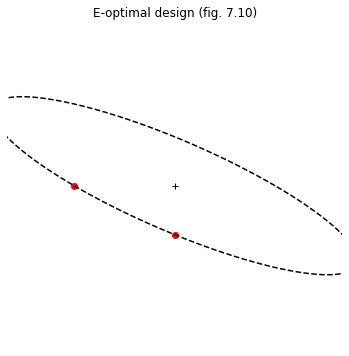

In [8]:
novars = n+1
c = matrix(0.0, (novars,1))
c[-1] = -1.0
Gs = [matrix(0.0, (4,novars))]
for k in range(n):  Gs[0][:,k] = -(V[:,k]*V[:,k].T)[:]
Gs[0][[0,3],-1] = 1.0
hs = [matrix(0.0, (2,2))]
Ge = matrix(0.0, (n, novars))
Ge[:,:n] = G
Ae = matrix(n*[1.0] + [0.0], (1,novars))
sol = solvers.sdp(c, Ge, h, Gs, hs, Ae, b)
xe = sol['x'][:n]
Z = sol['zs'][0]
mu = sol['y'][0]

if pylab_installed:
    pylab.figure(2, facecolor='w', figsize=(6,6))
    pylab.plot(V[0,:], V[1,:],'ow', [0], [0], 'k+')
    I = [ k for k in range(n) if xe[k] > 1e-5 ]
    pylab.plot(V[0,I], V[1,I],'or')

lapack.potrf(Z)
ellipse = sqrt(mu) * circle
blas.trsm(Z, ellipse, transA='T')
if pylab_installed:
    pylab.plot(ellipse[0,:].T, ellipse[1,:].T, 'k--')
    pylab.axis([-5, 5, -5, 5])
    pylab.title('E-optimal design (fig. 7.10)')
    pylab.axis('off')

Enclosing ellipse follows from the solution of the dual problem:
\begin{array}{l}
\text { min } m u \\
\text { S.t } \operatorname{diag}\left(V^{\prime} Z V\right) \leq m u 1 \\
\quad Z \geq 0
\end{array}


**A-design**
In A-optimal experiment design, we minimize $\operatorname{tr} E,$ the trace of the covariance matrix. This objective is simply the mean of the norm of the error squared:
$$
\mathbf{E}\|e\|_{2}^{2}=\mathbf{E} \operatorname{tr}\left(e e^{T}\right)=\mathbf{t r} E
$$
The $A$ -optimal experiment design problem is
\begin{array}{c}
\min \operatorname{tr}\left(V \operatorname{diag}(x) V^{\prime}\right)^{-1} \\
S. T. \ x \geq 0 \\
\sum x=1
\end{array}
.
$$
\begin{array}{l}
\text { min tr } Y \\
\text { S.T. }\left[V \operatorname{diag}(x) V^{\prime}, I\right] \\
\qquad[I, Y] \geq 0 \\
\quad \begin{array}{l}
x \geq 0 \\
\sum x=1
\end{array}
\end{array}
$$

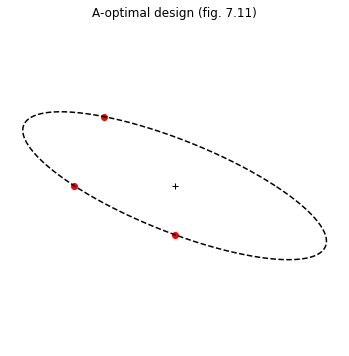

In [7]:
novars = 3 + n
c = matrix(0.0, (novars,1))
c[[-3, -1]] = 1.0
Gs = [matrix(0.0, (16, novars))]
for k in range(n):
    Gk = matrix(0.0, (4,4))
    Gk[:2,:2] = -V[:,k] * V[:,k].T
    Gs[0][:,k] = Gk[:]
Gs[0][10,-3] = -1.0
Gs[0][11,-2] = -1.0
Gs[0][15,-1] = -1.0
hs = [matrix(0.0, (4,4))]
hs[0][2,0] = 1.0
hs[0][3,1] = 1.0
Ga = matrix(0.0, (n, novars))
Ga[:,:n] = G
Aa = matrix(n*[1.0] + 3*[0.0], (1,novars))
sol = solvers.sdp(c, Ga, h, Gs, hs, Aa, b)
xa = sol['x'][:n]
Z = sol['zs'][0][:2,:2]
mu = sol['y'][0]

if pylab_installed:
    pylab.figure(3, facecolor='w', figsize = (6,6))
    pylab.plot(V[0,:], V[1,:],'ow', [0], [0], 'k+')
    I = [ k for k in range(n) if xa[k] > 1e-5 ]
    pylab.plot(V[0,I], V[1,I],'or')
  
lapack.potrf(Z)
ellipse = sqrt(mu) * circle
blas.trsm(Z, ellipse, transA='T')
if pylab_installed:
    pylab.plot(ellipse[0,:].T, ellipse[1,:].T, 'k--')
    pylab.axis([-5, 5, -5, 5])
    pylab.title('A-optimal design (fig. 7.11)')
    pylab.axis('off')
    pylab.show()

Enclosing ellipse follows from the solution of the dual problem:

$\begin{aligned} \max &-m u-2*tr Z12 \\ \text { s.t } & \operatorname{diag}\left(V^{\prime} Z11 V\right) \leq m u 1 \\ &[Z11,Z12] \\ &[Z21,I] \geq 0 \end{aligned}$

## References

* Original problem formulation:
  - S.P. Boyd, and L. Vandenberghe, Chapter 4. Convex Optimization. Cambridge University Press, New York, 2004.